# Using Autodistill to automatically label a Computer Vision Dataset

From the [Autodistill GitHub Repo](https://github.com/autodistill/autodistill): https://github.com/autodistill/autodistill

> Human labeling is one of the biggest barriers to broad adoption of computer vision. It can take thousands of hours to craft a dataset suitable for training a production model. The process of distillation for training supervised models is not new, in fact, traditional human labeling is just another form of distillation from an extremely capable Base Model (the human brain 🧠).

> Foundation models know a lot about a lot, but for production we need models that know a lot about a little.

> As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

In this notebook, we will use autodistill to label an image dataset.

## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
# Ensure access to GPU

!nvidia-smi

Thu Oct  3 23:50:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill, kaggle, and supervision

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In this notebook, we will use Grounded SAM as our Base Model.

In [ ]:
# Install dependencies

!pip install autodistill autodistill-grounded-sam supervision==0.9.0 kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you wan

## 🔑 Keep your keys secret

We can use Google Colab Secrets to keep our API keys hidden and outside of the notebook itself.

For this notebook, you will need `KAGGLE_USERNAME` and `KAGGLE_KEY` from [your Kaggle Settings](https://www.kaggle.com/settings) as well as a [Hugging Face user access token](https://huggingface.co/docs/hub/en/security-tokens), `HF_TOKEN`.

In [ ]:
import os
from google.colab import userdata

# To download our dataset from Kaggle, we need to setup our Kaggle API credentials.
# To use the Grounded SAM Foundation Model, we need to setup our Hugging Face Token

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

## 🖼️ Download an Image Dataset

Using the Kaggle API, we can download a dataset.  For this example, we will use the [Six-sided Dice Dataset from Nell Byler](https://www.kaggle.com/nellbyler/d6-dice).  It's technically already labeled but, for the sake of this example, we will autodistill the labels from the images

In [ ]:
import os
import shutil

# Create the ~/images directory for storing our training dataset

HOME = os.getcwd()
IMAGE_DIR_PATH = f"{HOME}/images"
!mkdir {HOME}/images

In [ ]:
# Download the dataset

!kaggle datasets download -d nellbyler/d6-dice

Dataset URL: https://www.kaggle.com/datasets/nellbyler/d6-dice
License(s): ODbL-1.0
 38% 11.0M/29.1M [00:00<00:00, 42.1MB/s]
100% 29.1M/29.1M [00:00<00:00, 85.7MB/s]


In [ ]:
# Unzip the dataset to a temporary location

!mkdir {HOME}/temp_images
TEMP_DIR_PATH = f"{HOME}/temp_images"
!unzip d6-dice.zip -d {TEMP_DIR_PATH}

# Move files from nested folder to the final images folder

for root, dirs, files in os.walk(TEMP_DIR_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        shutil.move(file_path, IMAGE_DIR_PATH)

# Clean up the temporary folder
shutil.rmtree(TEMP_DIR_PATH)

Archive:  d6-dice.zip
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111228.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111246.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111304.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111316.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111328.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111339.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111352.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111411.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111423.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111434.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111446.txt  
  inflating: /content/temp_images/d6-dice/Annotations/IMG_20191208_111457.txt  
  inflating: /cont

In [ ]:
# Confirm the number of images in our dataset

import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 500


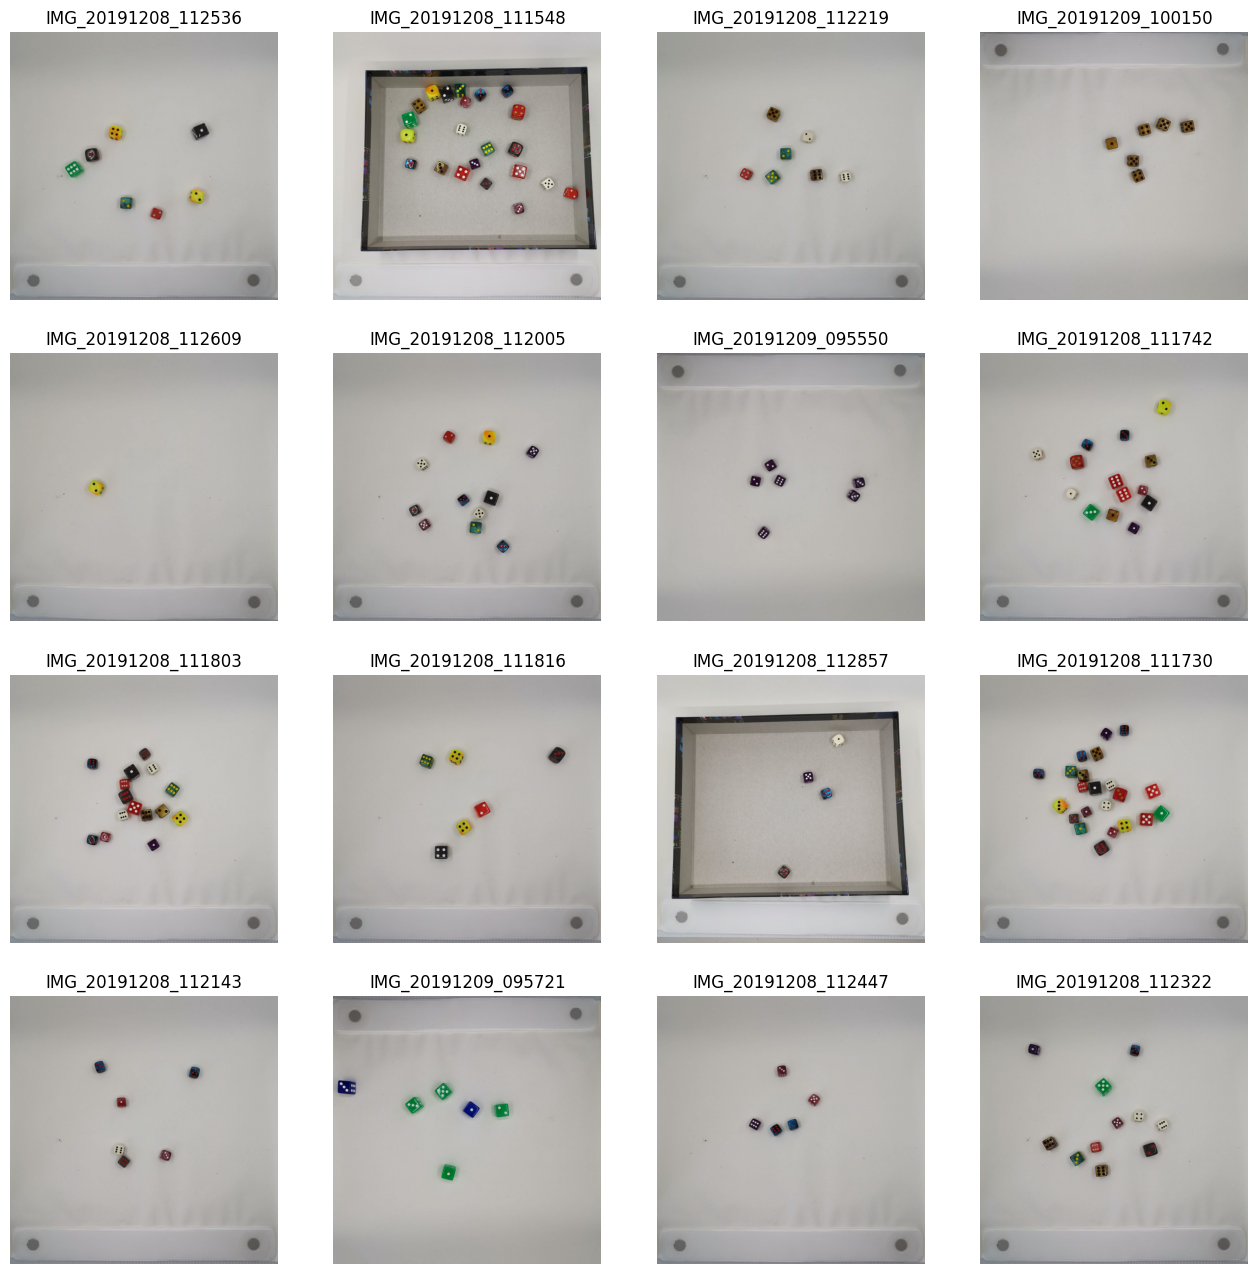

In [ ]:
# Plot some examples

import cv2
import supervision as sv

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

Now we can use autodistill to label our dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "dice": "dice",
    "background": "background"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [ ]:
# Make a Dataset folder

DATASET_DIR_PATH = f"{HOME}/dataset"

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

Labeled dataset created - ready for distillation.


### Display dataset sample

We now have an auto-labelled dataset generated by the Base Model.  This dataset could then be be used to train a Target Model (outside the scope of this notebook).

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset"

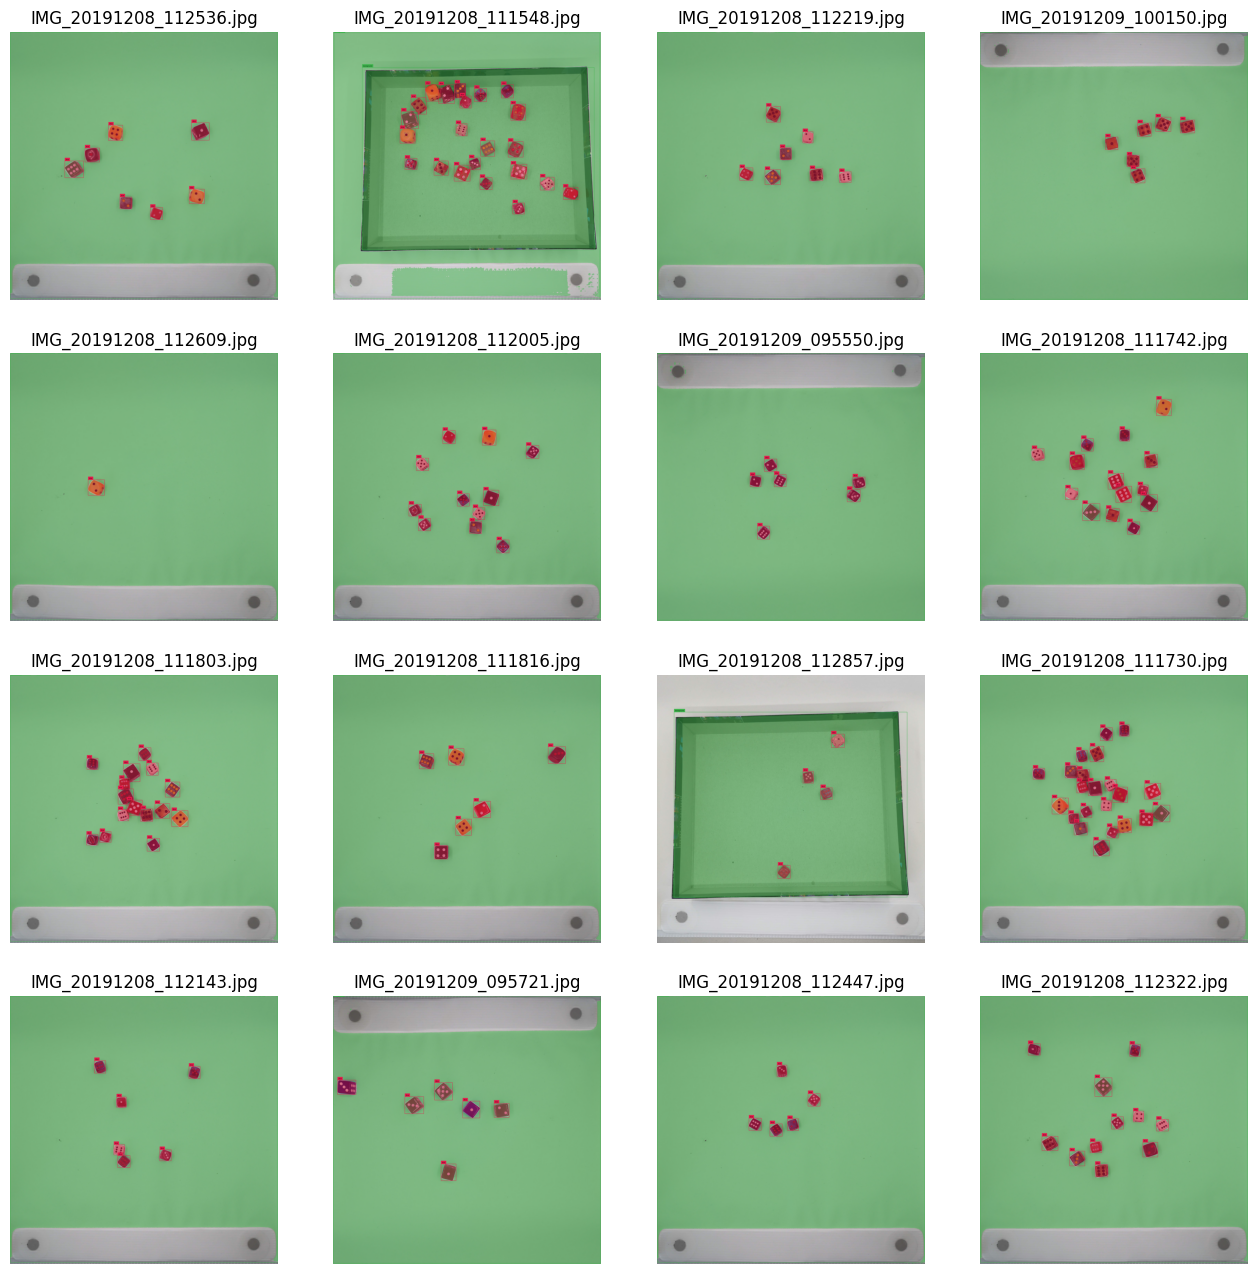

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)